In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd drive/MyDrive/ITMO/ITMO.Work/SCOPUS/AutoFormat

/content/drive/MyDrive/ITMO/ITMO.Work/SCOPUS/AutoFormat


In [ ]:
! ls

 best_model.pth		 catboost_model_ext.bin		    parsed_checked.csv	 X_y_train.csv
 catboost_info		'Copy of passages_research.ipynb'   parsed.csv
 catboost_model.bin	 extended_df.csv		    results_final.csv
 catboost_model_CV.bin	 mainDataset-all-cool.csv	    shap_values.pkl


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
values = {'bootstrap_type':0.21, 'l2_leaf_reg':0.15,
          'depth':0.15, 'colsample_bylevel':0.13,
          'random_strength':0.11, 'boosting_type':0.11, 'iterations':0.05}

importance_df = pd.DataFrame({'Parameter': list(values.keys()), 'Hyperarameter Importance': list(values.values())})

# Sort DataFrame by Importance in descending order
importance_df = importance_df.sort_values(by='Hyperarameter Importance', ascending=False)

# Create horizontal bar plot using Plotly Express
fig = px.bar(importance_df, x='Hyperarameter Importance', y='Parameter', orientation='h',
             title='Hyperarameter Importances', labels={'Hyperarameter Importance': 'Hyperarameter Importance', 'Parameter': 'Parameter'})

# Display values on bars
fig.update_traces(texttemplate='%{x}', textposition='inside')

fig.show()

## EDA

In [ ]:
df = pd.read_csv('mainDataset-all-cool.csv', sep=';')

In [ ]:
df = df.drop(['PrevElementMark', 'NextElementMark'], axis=1)

In [ ]:
parsed = pd.read_csv('parsed_checked.csv', sep=',')

In [ ]:
print(parsed[parsed['result']=='*'].shape[0])
print(parsed.shape[0])
print(parsed[parsed['result']=='*'].shape[0]/parsed.shape[0])

523
572
0.9143356643356644


In [ ]:
parsed.loc[parsed['FirstKeyWord_missed']==True, 'FirstKeyWord'] = np.NaN
parsed.loc[parsed['LastSymbolPd_missed']==True, 'LastSymbolPd'] = np.NaN

In [ ]:
parsed = parsed[parsed['result']=='*'].drop(['Content', 'proba', 'result', 'FirstKeyWord_missed', 'LastSymbolPd_missed'],axis=1)

In [ ]:
parsed = parsed.rename(columns={'Lowercase': 'lowercase',  'Uppercase' : 'uppercase'})

In [ ]:
col_ord = parsed.columns
df = df[col_ord]

In [ ]:
df = pd.concat([df, parsed])

In [ ]:
df[['LineSpacing', 'RightIndentation', 'SpaceAfter', 'SpaceBefore', 'SpecialIndentation', 'LeftIndentation']] = df[['LineSpacing', 'RightIndentation', 'SpaceAfter', 'SpaceBefore', 'SpecialIndentation', 'LeftIndentation']].astype(str)

In [ ]:
df.shape

(2442, 22)

In [ ]:
df.CurElementMark.value_counts()

CurElementMark
c1    1060
h1     334
d2     239
b2     234
b1     220
c2     212
f1      72
b3      49
g1      10
j0       6
i1       3
f3       2
e1       1
Name: count, dtype: int64

In [ ]:
df.isna().sum()

CurElementMark                            0
SpecialSymbolsCount                       0
WordsCount                                0
SymbolCount                               0
lowercase                                 0
uppercase                                 0
LastSymbolPd                            935
FirstKeyWord                           1413
FullBold                                  0
FullItalic                                0
Alignment                                 0
KeepLinesTogether                         0
KeepWithNext                              0
LeftIndentation                           0
LineSpacing                               0
NoSpaceBetweenParagraphsOfSameStyle       0
OutlineLevel                              0
PageBreakBefore                           0
RightIndentation                          0
SpaceAfter                                0
SpaceBefore                               0
SpecialIndentation                        0
dtype: int64

## Пара слов про датасет

CurElementMark -- целевая переменная, тип абзаца.

В этом поле с1 - обычный абзац, с2 - абзац перед списком, d2 - элемент списка, b1 - заголовок первого уровня и т.д. Всего было порядка 10 классов.

In [ ]:
df.FirstKeyWord.unique()

array([nan, 'listLevel1', 'TitleLevel1', 'TitleLevel2', 'Рисунок',
       'Выводы', 'Таблица', 'SHAPE', 'ВЫВОДЫ', '2.3.', 'PRESERVED',
       'TitleLevel3'], dtype=object)

In [ ]:
df.LastSymbolPd.unique()

array([nan, '.', ':', ';', ','], dtype=object)

In [ ]:
df.nunique()

CurElementMark                          13
SpecialSymbolsCount                     41
WordsCount                             137
SymbolCount                            607
lowercase                                2
uppercase                                2
LastSymbolPd                             4
FirstKeyWord                            11
FullBold                                 2
FullItalic                               2
Alignment                                4
KeepLinesTogether                        2
KeepWithNext                             2
LeftIndentation                         23
LineSpacing                             17
NoSpaceBetweenParagraphsOfSameStyle      2
OutlineLevel                             5
PageBreakBefore                          2
RightIndentation                         9
SpaceAfter                              22
SpaceBefore                             14
SpecialIndentation                      25
dtype: int64

In [ ]:
TARGET = 'CurElementMark'

NUM_FEATURES = ['SymbolCount', 'WordsCount', 'SpecialSymbolsCount']
CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET]

Сбалансирован ли?

SMOTE

In [ ]:
df[TARGET].value_counts()

CurElementMark
c1    1060
h1     334
d2     239
b2     234
b1     220
c2     212
f1      72
b3      49
g1      10
j0       6
i1       3
f3       2
e1       1
Name: count, dtype: int64

In [ ]:
df = df[df[TARGET] != 'e1']
df = df[~df[TARGET].isin(['f3', 'i1'])]
#for cross-val
df = df[~df[TARGET].isin(['j0', 'g1'])]

In [ ]:
df.to_csv('extended_df.csv', encoding='utf-8-sig', index=False)

In [ ]:
df = pd.read_csv('extended_df.csv')

In [ ]:
## target map

TARGET2INT = {t: num for num, t in enumerate(df[TARGET].unique())}
INT2TARGET = {t: num for num, t in TARGET2INT.items()}

In [ ]:
df[TARGET] = df[TARGET].apply(lambda x: TARGET2INT[x])

Заведем OHE и StandardScaler

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
!pip install optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, accuracy_score
import random

In [ ]:
import shap

In [ ]:
import optuna
from optuna.integration.sklearn import OptunaSearchCV
from optuna.integration import CatBoostPruningCallback
from optuna.distributions import FloatDistribution, IntDistribution

import matplotlib.pyplot as plt
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

train_size= 0.8

X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), df[TARGET], stratify=df[TARGET],
                                                    random_state=RANDOM_SEED, train_size=train_size)

Пропуски

In [ ]:
FEATURES_WITH_MISSINGS = ['FirstKeyWord', 'LastSymbolPd']
FEATURES_WITH_MISSINGS_INDICATORS = [f + "_missed" for f in FEATURES_WITH_MISSINGS]


imputer = SimpleImputer(strategy='most_frequent', add_indicator=True)
imputer.fit(X_train[FEATURES_WITH_MISSINGS])

X_train[FEATURES_WITH_MISSINGS + FEATURES_WITH_MISSINGS_INDICATORS] = imputer.transform(X_train[FEATURES_WITH_MISSINGS])
X_test[FEATURES_WITH_MISSINGS + FEATURES_WITH_MISSINGS_INDICATORS] = imputer.transform(X_test[FEATURES_WITH_MISSINGS])

In [ ]:
catboost_train_f = NUM_FEATURES+CAT_FEATURES + FEATURES_WITH_MISSINGS_INDICATORS

In [ ]:
df_test = X_test.copy()
df_test['CurElementMark'] = y_test
d2_test = df_test[(df_test['CurElementMark']==3)&(df_test['FirstKeyWord_missed'])]

## Optuna

No SMOTE here

No Feature Engineering here

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

### Optuna (OneVsRest AUC)

No SHAP

Got us the best classifier (clf_temp)

In [ ]:
def objective(trial: optuna.Trial) -> float:
    train_x, valid_x, train_y, valid_y = train_test_split(X_train[catboost_train_f], y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train)

    param = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "10gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    clf = CatBoostClassifier(
        cat_features=CAT_FEATURES,
        random_seed=RANDOM_SEED,
        task_type='CPU',
        **param
    )

    clf.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
    )

    preds_proba = clf.predict_proba(valid_x)
    roc_auc = roc_auc_score(valid_y, preds_proba, multi_class='ovr')

    return roc_auc

In [ ]:
study_auc = optuna.create_study(direction="maximize")
study_auc.optimize(objective, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study_auc.trials)))
print("Best trial:")
trial = study_auc.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-04 22:08:49,830] A new study created in memory with name: no-name-199f193f-ec35-4cb5-bbc1-a7db4b03e4d4
[I 2024-04-04 22:08:58,448] Trial 0 finished with value: 0.9895470638319952 and parameters: {'iterations': 459, 'learning_rate': 0.0022694677315482775, 'l2_leaf_reg': 0.00017777731584534383, 'random_strength': 0.11407893093579696, 'colsample_bylevel': 0.030945749079410247, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9895470638319952.
[I 2024-04-04 22:09:07,119] Trial 1 finished with value: 0.9853633595094327 and parameters: {'iterations': 424, 'learning_rate': 0.01974498187300854, 'l2_leaf_reg': 1.6883218595337907e-08, 'random_strength': 0.6258394406570579, 'colsample_bylevel': 0.018826982467249426, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5880644955536424}. Best is trial 0 with value: 0.9895470638319952.
[I 2024-04-04 22:09:11,944] Trial 2 finished with value: 0.978793410087598

Number of finished trials: 100
Best trial:
  Value: 0.9988908926301617
  Params: 
    iterations: 273
    learning_rate: 0.0947011408639315
    l2_leaf_reg: 3.274862715651759e-08
    random_strength: 1.0855238292221214e-07
    colsample_bylevel: 0.04716648113056018
    depth: 6
    boosting_type: Ordered
    bootstrap_type: MVS


Number of finished trials: 100

Best trial:

  Value: 0.9988908926301617

  Params:
  
    iterations: 273
    learning_rate: 0.0947011408639315
    l2_leaf_reg: 3.274862715651759e-08
    random_strength: 1.0855238292221214e-07
    colsample_bylevel: 0.04716648113056018
    depth: 6
    boosting_type: Ordered
    bootstrap_type: MVS

### clf_ext

Number of finished trials: 100

Best trial:

  Value: 0.9987200456871321

  Params:
  
    iterations: 950
    learning_rate: 0.03479807319317012
    l2_leaf_reg: 6.825542289645035e-05
    random_strength: 0.004499314851104614
    colsample_bylevel: 0.05782275246348402
    depth: 8
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 5.428329074740009

In [ ]:
plt.tight_layout()
plot_contour(study_auc)

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_edf(study_auc)

In [ ]:
plot_optimization_history(study_auc)

In [ ]:
plot_parallel_coordinate(study_auc)

[W 2024-04-04 23:20:11,347] Your study has only completed trials with missing parameters.


In [ ]:
plot_param_importances(study_auc)

In [ ]:
plot_slice(study_auc)

### clf_temp

Number of finished trials: 12

Best trial:

  Value: 0.9976396507312932

  Params:
  
    iterations: 986
    learning_rate: 0.021364321506321674
    l2_leaf_reg: 1.5581588684805854e-06
    random_strength: 0.00381610114894751
    colsample_bylevel: 0.08309710472864541
    depth: 12
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.9890019043511935

In [ ]:
plt.tight_layout()
plot_contour(study_auc)

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_edf(study_auc)

In [ ]:
plot_optimization_history(study_auc)

In [ ]:
plot_parallel_coordinate(study_auc)

[W 2024-04-02 20:06:01,108] Your study has only completed trials with missing parameters.


In [ ]:
plot_param_importances(study_auc)

In [ ]:
plot_slice(study_auc)

### clf_best

Number of finished trials: 2

Best trial:

  Value: 0.9989422501987754

  Params:
  
    iterations: 818
    learning_rate: 0.06039931519812003
    l2_leaf_reg: 0.004931235416826599
    random_strength: 0.6636501599265416
    colsample_bylevel: 0.06883539828411236
    depth: 12
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 3.2075291028580244

In [ ]:
plot_contour(study_auc)

[W 2024-04-01 10:55:51,610] Param boosting_type unique value length is less than 2.
[W 2024-04-01 10:55:51,613] Param bootstrap_type unique value length is less than 2.
[W 2024-04-01 10:55:51,615] Param depth unique value length is less than 2.
[W 2024-04-01 10:55:51,616] Param boosting_type unique value length is less than 2.
[W 2024-04-01 10:55:51,618] Param bootstrap_type unique value length is less than 2.
[W 2024-04-01 10:55:51,619] Param boosting_type unique value length is less than 2.
[W 2024-04-01 10:55:51,620] Param depth unique value length is less than 2.
[W 2024-04-01 10:55:51,622] Param boosting_type unique value length is less than 2.
[W 2024-04-01 10:55:51,623] Param boosting_type unique value length is less than 2.
[W 2024-04-01 10:55:51,624] Param boosting_type unique value length is less than 2.
[W 2024-04-01 10:55:51,625] Param boosting_type unique value length is less than 2.
[W 2024-04-01 10:55:51,626] Param bootstrap_type unique value length is less than 2.
[W 20

In [ ]:
plot_edf(study_auc)

In [ ]:
plot_optimization_history(study_auc)

In [ ]:
plot_parallel_coordinate(study_auc)

In [ ]:
plot_param_importances(study_auc)

In [ ]:
plot_slice(study_auc)

### Optuna on Accuracy with Pruning + SHAP

In [ ]:
from typing import Tuple
import warnings

warnings.filterwarnings("ignore")

In [ ]:
def objective_ac(trial: optuna.Trial) -> Tuple[float, np.array]:
    train_x, valid_x, train_y, valid_y = train_test_split(X_train[catboost_train_f], y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train)

    param = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "10gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    clf = CatBoostClassifier(
        cat_features=CAT_FEATURES,
        random_seed=RANDOM_SEED,
        task_type='CPU',
        **param
    )

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    clf.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = clf.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)

    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(valid_x)

    return accuracy, shap_values

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)

shap_values = []

for _ in range(100):
    trial = study.ask()
    try:
        accuracy, shap_values_fold = objective_ac(trial)
        study.tell(trial, accuracy)
        shap_values.append(shap_values_fold)
    except Exception:
        pass

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

shap_values = np.concatenate(shap_values, axis=0)

[I 2024-04-01 09:37:21,367] A new study created in memory with name: no-name-94f66d62-abc1-4536-b06e-71c69995ba6d


Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was pruned.
Trial was 

ValueError: Must pass 2-d input. shape=(3060, 23, 10)

In [ ]:
import pickle

with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [ ]:
!ls

 catboost_info	'Copy of passages_research.ipynb'   mainDataset-all-cool.csv   shap_values.pkl


In [ ]:
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

Number of finished trials: 100

Best trial:

  Value: 0.9673202614379085

  Params:
  
    iterations: 493
    learning_rate: 0.03235331652068283
    l2_leaf_reg: 4.123056939928937e-05
    random_strength: 1.0544488739820115
    colsample_bylevel: 0.04919598189063787
    depth: 12
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.21287606197015024

In [ ]:
plot_contour(study)

In [ ]:
plot_edf(study)

In [ ]:
plot_intermediate_values(study)

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

## Fit catboost with finetuned params and evaluate on test

###Classifiers

1. Catboost optuned on Accuracy with pruning

In [ ]:
clf_acc = CatBoostClassifier(
    cat_features=CAT_FEATURES,
    random_seed=RANDOM_SEED,
    task_type='CPU',
    iterations = 493,
    learning_rate = 0.03235331652068283,
    l2_leaf_reg = 4.123056939928937e-05,
    random_strength = 1.0544488739820115,
    colsample_bylevel = 0.04919598189063787,
    depth = 12,
    boosting_type = 'Plain',
    bootstrap_type = 'Bernoulli',
    subsample = 0.21287606197015024,
    auto_class_weights='SqrtBalanced',
    loss_function='MultiClass'
)

2. CatBoost optuned on AUC w/o pruning

In [ ]:
clf_best = CatBoostClassifier(
    cat_features=CAT_FEATURES,
    random_seed=RANDOM_SEED,
    task_type='CPU',
    iterations = 818,
    learning_rate = 0.06039931519812003,
    l2_leaf_reg = 0.004931235416826599,
    random_strength = 0.6636501599265416,
    colsample_bylevel = 0.06883539828411236,
    depth = 12,
    boosting_type = 'Ordered', #check hyperparam
    bootstrap_type = 'Bayesian',
    bagging_temperature = 3.2075291028580244,
    auto_class_weights='SqrtBalanced',
    loss_function='MultiClass'
)

3. clf_temp model, but boosting type = 'Plain' (for interpretation)

In [ ]:
clf_interpret1 = CatBoostClassifier(
    cat_features=CAT_FEATURES,
    random_seed=RANDOM_SEED,
    task_type='CPU',
    iterations = 818,
    learning_rate = 0.06039931519812003,
    l2_leaf_reg = 0.004931235416826599,
    random_strength = 0.6636501599265416,
    colsample_bylevel = 0.06883539828411236,
    depth = 12,
    boosting_type = 'Plain',
    bootstrap_type = 'Bayesian',
    bagging_temperature = 3.2075291028580244,
    auto_class_weights='SqrtBalanced',
    loss_function='MultiClass'
)

4. clf_temp model, but bootstrap_type = Bernoulli (for interpretation)

In [ ]:
clf_interpret2 = CatBoostClassifier(
    cat_features=CAT_FEATURES,
    random_seed=RANDOM_SEED,
    task_type='CPU',
    iterations = 818,
    learning_rate = 0.06039931519812003,
    l2_leaf_reg = 0.004931235416826599,
    random_strength = 0.6636501599265416,
    colsample_bylevel = 0.06883539828411236,
    depth = 12,
    boosting_type = 'Ordered',
    bootstrap_type = 'Bernoulli',
    subsample = 0.21287606197015024,
    auto_class_weights='SqrtBalanced',
    loss_function='MultiClass'
)

5. Catboost optuned on Accuracy with pruning WITH positional marks

In [ ]:
clf_acc_pos = CatBoostClassifier(
    cat_features=CAT_FEATURES,
    random_seed=RANDOM_SEED,
    task_type='CPU',
    iterations = 493,
    learning_rate = 0.03235331652068283,
    l2_leaf_reg = 4.123056939928937e-05,
    random_strength = 1.0544488739820115,
    colsample_bylevel = 0.04919598189063787,
    depth = 12,
    boosting_type = 'Plain',
    bootstrap_type = 'Bernoulli',
    subsample = 0.21287606197015024,
    auto_class_weights='SqrtBalanced',
    loss_function='MultiClass'
)

6. CatBoost optuned on AUC with CV

In [ ]:
clf_temp = CatBoostClassifier(
    cat_features=CAT_FEATURES,
    random_seed=RANDOM_SEED,
    task_type='CPU',
    iterations = 986,
    learning_rate = 0.021364321506321674,
    l2_leaf_reg = 1.5581588684805854e-06,
    random_strength = 0.00381610114894751,
    colsample_bylevel = 0.08309710472864541,
    depth = 12,
    boosting_type = 'Ordered',
    bootstrap_type = 'Bernoulli',
    subsample = 0.9890019043511935,
    auto_class_weights='SqrtBalanced',
    loss_function='MultiClass'
)

In [ ]:
best_params_ext = {'iterations': 950, 'learning_rate': 0.03479807319317012, 'l2_leaf_reg': 6.825542289645035e-05, 'random_strength': 0.004499314851104614, 'colsample_bylevel': 0.05782275246348402, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.428329074740009}

In [ ]:
clf_ext = CatBoostClassifier(
    cat_features=CAT_FEATURES,
    random_seed=RANDOM_SEED,
    task_type='CPU',
    **best_params_ext,
    auto_class_weights='SqrtBalanced',
    loss_function='MultiClass'
)

In [ ]:
clf_acc.fit(X_train[catboost_train_f], y_train, eval_set=(X_test[catboost_train_f], y_test),
             verbose=500, use_best_model=True, plot=False)

0:	learn: 1.9268874	test: 1.9264685	best: 1.9264685 (0)	total: 65.6ms	remaining: 32.3s
492:	learn: 0.0255826	test: 0.0976235	best: 0.0975947 (491)	total: 1m 7s	remaining: 0us

bestTest = 0.09759467382
bestIteration = 491

Shrink model to first 492 iterations.


In [ ]:
clf_best.fit(X_train[catboost_train_f], y_train, eval_set=(X_test[catboost_train_f], y_test),
        verbose=500, use_best_model=True, plot=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2008158	test: 2.1978771	best: 2.1978771 (0)	total: 87.3ms	remaining: 1m 11s
500:	learn: 0.0029270	test: 0.1318462	best: 0.1271271 (337)	total: 1h 3m 47s	remaining: 40m 21s
817:	learn: 0.0007912	test: 0.1474183	best: 0.1271271 (337)	total: 1h 53m 45s	remaining: 0us

bestTest = 0.1271271193
bestIteration = 337

Shrink model to first 338 iterations.


In [ ]:
clf_interpret1.fit(X_train[catboost_train_f], y_train, eval_set=(X_test[catboost_train_f], y_test),
        verbose=500, use_best_model=True, plot=False)

Learning rate set to 0.10977
0:	learn: 1.8970060	test: 1.9213928	best: 1.9213928 (0)	total: 368ms	remaining: 6m 7s
500:	learn: 0.0054881	test: 0.1952502	best: 0.1928655 (230)	total: 2m 7s	remaining: 2m 6s
999:	learn: 0.0024464	test: 0.2016058	best: 0.1928655 (230)	total: 4m 5s	remaining: 0us
bestTest = 0.1928655409
bestIteration = 230
Shrink model to first 231 iterations.


In [ ]:
clf_interpret2.fit(X_train[catboost_train_f], y_train, eval_set=(X_test[catboost_train_f], y_test),
        verbose=500, use_best_model=True, plot=False)

In [ ]:
clf_acc_pos.fit(X_train[catboost_train_f], y_train, eval_set=(X_test[catboost_train_f], y_test),
        verbose=500, use_best_model=True, plot=False)

0:	learn: 2.2081909	test: 2.2075947	best: 2.2075947 (0)	total: 18ms	remaining: 8.88s
492:	learn: 0.0090355	test: 0.1551788	best: 0.1529627 (480)	total: 2m 33s	remaining: 0us

bestTest = 0.1529627252
bestIteration = 480

Shrink model to first 481 iterations.


In [ ]:
clf_temp.fit(X_train[catboost_train_f], y_train, eval_set=(X_test[catboost_train_f], y_test),
        verbose=500, use_best_model=True, plot=False)

0:	learn: 1.9742503	test: 1.9777799	best: 1.9777799 (0)	total: 859ms	remaining: 14m 5s
500:	learn: 0.0171591	test: 0.1115662	best: 0.1112728 (471)	total: 25m 39s	remaining: 24m 49s
985:	learn: 0.0033898	test: 0.1383802	best: 0.1112728 (471)	total: 59m 51s	remaining: 0us

bestTest = 0.1112727597
bestIteration = 471

Shrink model to first 472 iterations.


In [ ]:
X_train[catboost_train_f]

,SymbolCount,WordsCount,SpecialSymbolsCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,FullBold,FullItalic,Alignment,KeepLinesTogether,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation,FirstKeyWord_missed,LastSymbolPd_missed
822,163.0,19.0,4,False,False,.,Рисунок,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",True,False
564,31.0,5.0,1,False,False,.,Таблица,False,False,Justify,False,False,0.0,1.5,False,BodyText,False,0.0,0.0,0.0,0.0,False,True
942,342.0,34.0,7,False,False,.,Рисунок,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,-36,True,False
377,20.0,3.0,1,False,False,.,TitleLevel3,True,False,Left,True,True,35.45,1.5,False,Level2,False,0.0,0.0,0.0,0.0,False,True
1011,81.0,9.0,1,False,False,.,Таблица,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,375.0,45.0,11,False,False,.,Рисунок,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",True,False
1483,69.0,6.0,3,False,False,:,Рисунок,False,False,Justify,False,False,0,"1,5",True,BodyText,False,0,0,0.0,"-35,45",True,False
682,36.0,4.0,1,False,False,.,Рисунок,False,False,Center,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,True
1655,30.0,6.0,2,False,False,:,Рисунок,False,False,Justify,False,False,0,"1,5",True,BodyText,False,"-14,2",0,0.0,"-35,45",True,False


In [ ]:
import time
start = time.time()
clf_ext.fit(X_train[catboost_train_f], y_train, eval_set=(X_test[catboost_train_f], y_test),
        verbose=500, use_best_model=True, plot=False)
end = time.time()
print('Time elapsed: ', end-start)

0:	learn: 2.0538328	test: 2.0528613	best: 2.0528613 (0)	total: 68.4ms	remaining: 1m 4s
500:	learn: 0.0371987	test: 0.0715965	best: 0.0715965 (500)	total: 58.3s	remaining: 52.3s
949:	learn: 0.0113793	test: 0.0638981	best: 0.0609732 (750)	total: 1m 45s	remaining: 0us

bestTest = 0.06097324754
bestIteration = 750

Shrink model to first 751 iterations.
Time elapsed:  110.40258979797363


### Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
y_pred = clf_acc.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB on Accuracy')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

Evaluation for CB on Accuracy
              precision    recall  f1-score   support

          b1       1.00      1.00      1.00        44
          b2       1.00      1.00      1.00        47
          b3       1.00      0.80      0.89        10
          c1       0.98      0.99      0.98       212
          c2       0.95      1.00      0.98        42
          d2       0.98      0.94      0.96        48
          f1       1.00      1.00      1.00        14
          h1       1.00      1.00      1.00        67

    accuracy                           0.98       484
   macro avg       0.99      0.97      0.98       484
weighted avg       0.98      0.98      0.98       484



In [ ]:
y_pred = clf_best.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB on AUC v2')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

Evaluation for CB on AUC v2
              precision    recall  f1-score   support

          b1       0.91      1.00      0.95        10
          b2       1.00      0.94      0.97        16
          b3       0.89      0.89      0.89         9
          c1       0.98      0.99      0.98       212
          c2       0.95      0.98      0.96        42
          d2       0.98      0.94      0.96        48
          f1       1.00      1.00      1.00        10
          g1       1.00      1.00      1.00         2
          h1       1.00      1.00      1.00        33
          i1       1.00      1.00      1.00         1
          j0       1.00      1.00      1.00         1

    accuracy                           0.98       384
   macro avg       0.97      0.98      0.97       384
weighted avg       0.98      0.98      0.98       384



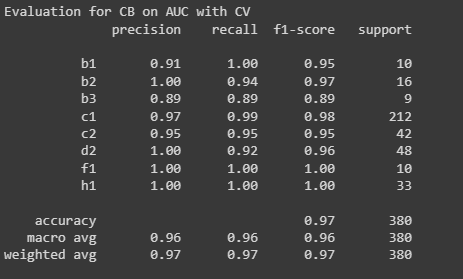

In [ ]:
y_pred = clf_interpret1.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB for interpretetion of clf_temp 1')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

Evaluation for CB on GPU with Bernoulli bootstrap
              precision    recall  f1-score   support

          b1       1.00      1.00      1.00        10
          b2       0.94      0.94      0.94        16
          b3       0.73      0.89      0.80         9
          c1       0.97      0.98      0.98       212
          c2       0.93      0.95      0.94        42
          d2       0.95      0.88      0.91        48
          f1       1.00      0.90      0.95        10
          g1       1.00      1.00      1.00         2
          h1       0.97      0.97      0.97        33
          j0       1.00      1.00      1.00         1

    accuracy                           0.96       383
   macro avg       0.95      0.95      0.95       383
weighted avg       0.96      0.96      0.96       383



In [ ]:
y_pred = clf_interpret2.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB for interpretetion of clf_temp 2')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

In [ ]:
y_pred = clf_acc_pos.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB on Accuracy with positions')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

Evaluation for CB on Accuracy with positions
              precision    recall  f1-score   support

          b1       0.83      1.00      0.91        10
          b2       0.88      0.94      0.91        16
          b3       1.00      0.67      0.80         9
          c1       0.97      0.99      0.98       212
          c2       0.98      0.95      0.96        42
          d2       0.98      0.92      0.95        48
          f1       1.00      0.90      0.95        10
          g1       1.00      1.00      1.00         2
          h1       0.97      1.00      0.99        33
          j0       1.00      1.00      1.00         1

    accuracy                           0.97       383
   macro avg       0.96      0.94      0.94       383
weighted avg       0.97      0.97      0.97       383



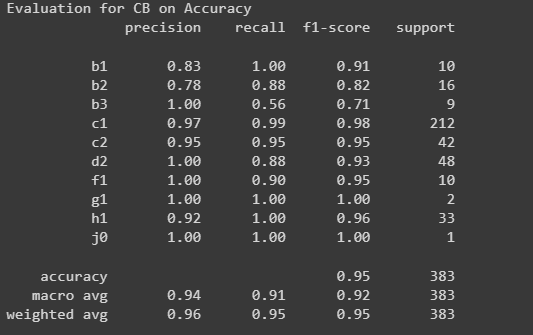

In [ ]:
y_pred = clf_temp.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB on AUC with CV')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

Evaluation for CB on AUC with CV
              precision    recall  f1-score   support

          b1       0.83      1.00      0.91        10
          b2       1.00      0.94      0.97        16
          b3       1.00      1.00      1.00         9
          c1       0.97      0.99      0.98       212
          c2       0.95      0.95      0.95        42
          d2       1.00      0.92      0.96        48
          f1       1.00      1.00      1.00        10
          h1       1.00      1.00      1.00        33

    accuracy                           0.97       380
   macro avg       0.97      0.97      0.97       380
weighted avg       0.97      0.97      0.97       380



In [ ]:
y_pred = clf_temp.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB on AUC with CV')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

NameError: name 'clf_temp' is not defined

In [ ]:
y_pred = clf_ext.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

y_pred_txt = list(map(lambda x: INT2TARGET[x], y_pred))
y_test_txt = list(map(lambda x: INT2TARGET[x], y_test))

print('Evaluation for CB optuned on AUC with extended dataset')
for line in classification_report(y_test_txt, y_pred_txt).split('\n'):
    print(line)

Evaluation for CB optuned on AUC with extended dataset
              precision    recall  f1-score   support

          b1       1.00      1.00      1.00        44
          b2       1.00      1.00      1.00        47
          b3       1.00      0.80      0.89        10
          c1       0.98      0.99      0.98       212
          c2       0.95      1.00      0.98        42
          d2       0.98      0.94      0.96        48
          f1       1.00      1.00      1.00        14
          h1       1.00      1.00      1.00        67

    accuracy                           0.98       484
   macro avg       0.99      0.97      0.98       484
weighted avg       0.98      0.98      0.98       484



In [ ]:
sorted(INT2TARGET.values())

['b1', 'b2', 'b3', 'c1', 'c2', 'd2', 'f1', 'h1']

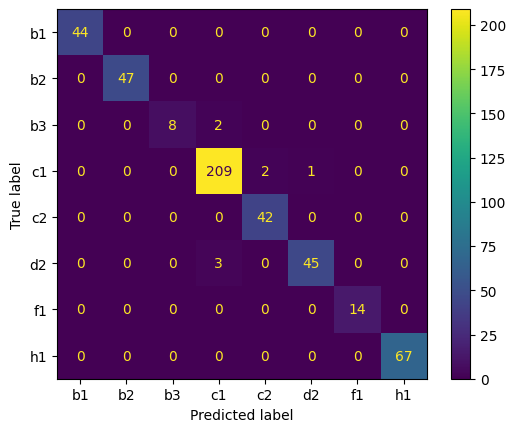

In [ ]:
class_names = sorted(INT2TARGET.values())
cm = confusion_matrix(y_test_txt, y_pred_txt)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot()

In [ ]:
model_path = 'catboost_model_ext.bin'
clf_ext.save_model(model_path)

print("Model saved successfully at:", model_path)

Model saved successfully at: catboost_model_ext.bin


In [ ]:
model_path = 'catboost_model_ext.bin'
clf_ext = CatBoostClassifier()
clf_ext.load_model(model_path)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
y_pred = clf_ext.predict_proba(X_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

In [ ]:
d2_test[catboost_train_f]

,SymbolCount,WordsCount,SpecialSymbolsCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,FullBold,FullItalic,Alignment,KeepLinesTogether,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation,FirstKeyWord_missed,LastSymbolPd_missed
75,35.0,3.0,1,True,False,;,Рисунок,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,0,True,False
1563,57.0,8.0,5,True,False,.,Рисунок,False,False,Justify,False,False,0,"1,5",True,BodyText,False,0,0,0.0,"-35,45",True,False
710,54.0,5.0,1,True,False,:,Рисунок,False,False,Left,False,False,0,"1,5",False,BodyText,False,0,0,0.0,0,True,False
738,105.0,14.0,4,False,False,.,Рисунок,False,False,Left,False,False,0,"1,5",False,BodyText,False,0,0,0.0,0,True,True
718,52.0,5.0,0,True,False,.,Рисунок,False,False,Left,False,False,0,"1,5",False,BodyText,False,0,0,0.0,0,True,True


In [ ]:
y_pred = clf_ext.predict_proba(d2_test[catboost_train_f])
y_pred = y_pred.argmax(axis=1)

In [ ]:
y_pred

array([3, 1, 3, 1, 1])

In [ ]:
df_train = X_train.copy()
df_train['CurElementMark'] = y_train

In [ ]:
df_train[(df_train['LastSymbolPd']=='.')&(df_train['CurElementMark']==3)]

,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,FullBold,FullItalic,Alignment,KeepLinesTogether,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation,FirstKeyWord_missed,LastSymbolPd_missed,CurElementMark
506,12,24.0,223.0,False,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,False,3
1381,3,12.0,78.0,False,False,.,Рисунок,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",True,False,3
122,3,11.0,68.0,False,False,.,listLevel1,False,False,Justify,False,False,0,1,False,BodyText,False,0,0,0.0,"-35,45",False,True,3
51,2,3.0,19.0,True,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,False,3
1797,2,7.0,47.0,False,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",True,BodyText,False,0,0,0.0,"-35,45",False,False,3
621,17,33.0,268.0,False,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,False,3
76,2,4.0,31.0,True,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,False,3
505,10,23.0,216.0,False,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,False,3
39,1,2.0,11.0,False,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,True,3
619,6,27.0,257.0,False,False,.,listLevel1,False,False,Justify,False,False,0,"1,5",False,BodyText,False,0,0,0.0,"-35,45",False,False,3


In [ ]:
d2_test[catboost_train_f].iloc[[1,3,4]]

,SymbolCount,WordsCount,SpecialSymbolsCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,FullBold,FullItalic,Alignment,KeepLinesTogether,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation,FirstKeyWord_missed,LastSymbolPd_missed
1563,57.0,8.0,5,True,False,.,Рисунок,False,False,Justify,False,False,0,"1,5",True,BodyText,False,0,0,0.0,"-35,45",True,False
738,105.0,14.0,4,False,False,.,Рисунок,False,False,Left,False,False,0,"1,5",False,BodyText,False,0,0,0.0,0,True,True
718,52.0,5.0,0,True,False,.,Рисунок,False,False,Left,False,False,0,"1,5",False,BodyText,False,0,0,0.0,0,True,True


In [ ]:
model_path = 'catboost_model_CV.bin'
clf_best.save_model(model_path)

print("Model saved successfully at:", model_path)

Model saved successfully at: catboost_model_CV.bin


In [ ]:
model_path = 'catboost_model.bin'
clf_best.save_model(model_path)

print("Model saved successfully at:", model_path)

Model saved successfully at: catboost_model.bin


In [ ]:
!ls

 best_model.pth		 catboost_model_ext.bin		    parsed_checked.csv
 catboost_info		'Copy of passages_research.ipynb'   parsed.csv
 catboost_model.bin	 extended_df.csv		    results_final.csv
 catboost_model_CV.bin	 mainDataset-all-cool.csv	    shap_values.pkl


In [ ]:
model_path = 'catboost_model.bin'
best_model = CatBoostClassifier()
best_model.load_model(model_path)

Without finetuning:


              precision    recall  f1-score   support

          b1       0.91      1.00      0.95        10
          b2       1.00      0.94      0.97        16
          b3       0.80      0.89      0.84         9
          c1       0.98      0.98      0.98       212
          c2       0.95      0.95      0.95        42
          d2       0.98      0.94      0.96        48
          f1       0.91      1.00      0.95        10
          g1       1.00      1.00      1.00         2
          h1       1.00      0.97      0.98        33
          i1       1.00      1.00      1.00         1
          j0       1.00      1.00      1.00         1

    accuracy                           0.97       384
```
   macro avg    0.96      0.97      0.96       384
   
weighted avg    0.97      0.97      0.97       384

```


In [ ]:
INT2TARGET

{0: 'b1', 1: 'c1', 2: 'c2', 3: 'd2', 4: 'b2', 5: 'h1', 6: 'b3', 7: 'f1'}

In [ ]:
TARGET2INT

{'b1': 0, 'c1': 1, 'c2': 2, 'd2': 3, 'b2': 4, 'h1': 5, 'b3': 6, 'f1': 7}

## LSTM

### Chains

In [ ]:
df = pd.read_csv('mainDataset-all-cool.csv', sep=';')

In [ ]:
df.columns

Index(['SpecialSymbolsCount', 'WordsCount', 'SymbolCount', 'lowercase',
       'uppercase', 'LastSymbolPd', 'FirstKeyWord', 'PrevElementMark',
       'CurElementMark', 'NextElementMark', 'FullBold', 'FullItalic',
       'Alignment', 'KeepLinesTogether', 'KeepWithNext', 'LeftIndentation',
       'LineSpacing', 'NoSpaceBetweenParagraphsOfSameStyle', 'OutlineLevel',
       'PageBreakBefore', 'RightIndentation', 'SpaceAfter', 'SpaceBefore',
       'SpecialIndentation'],
      dtype='object')

In [ ]:
df.shape

(1919, 24)

In [ ]:
df

,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,PrevElementMark,CurElementMark,NextElementMark,...,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
0,0,1,8,False,False,NaN,NaN,c1,b1,c1,...,True,0,"1,5",False,Level1,False,0,0,0,"-35,45"
1,9,48,386,False,False,.,NaN,b1,c1,c1,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
2,12,67,535,False,False,.,NaN,c1,c1,c1,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
3,11,54,405,False,False,.,NaN,c1,c1,c2,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
4,1,5,37,False,False,:,NaN,c1,c2,d1,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,5,21,184,False,False,.,NaN,d2,c1,b1,...,False,0,"1,5",False,BodyText,False,0,0,12,"-35,45"
1915,0,1,10,False,True,NaN,NaN,c1,b1,c1,...,True,0,"1,5",False,Level1,False,0,12,0,0
1916,9,57,486,False,False,.,NaN,b1,c1,c1,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
1917,4,49,365,False,False,.,NaN,c1,c1,c1,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"


In [ ]:
excluded_classes = {'e1', 'i1', 'f3', 'j0', 'g1'}

chains = []

curr_chain = []
for ind in range(1, len(df)):
  cur_row_cur_mark = df.loc[ind, 'CurElementMark']
  cur_row_next_mark = df.loc[ind, 'NextElementMark']

  prev_row_cur_mark = df.loc[ind-1, 'CurElementMark']
  prev_row_next_mark = df.loc[ind-1, 'NextElementMark']

  if cur_row_cur_mark in excluded_classes:
    if cur_row_cur_mark in curr_chain:
        curr_chain.remove(cur_row_cur_mark)
  else:
    if cur_row_cur_mark == prev_row_next_mark:
      if len(curr_chain) == 0:
        curr_chain.append(prev_row_cur_mark)
        curr_chain.append(cur_row_cur_mark)
      else:
        curr_chain.append(cur_row_cur_mark)
    else:
      chains.append(curr_chain)
      curr_chain = []

if curr_chain:
  chains.append(curr_chain)

In [ ]:
thresh_len = 4

chains = list(filter(lambda x: len(x) > thresh_len, chains))
len(chains)

134

In [ ]:
from collections import Counter

chain_elements = [element for chain in chains for element in chain]

class_counter = Counter(chain_elements)

print("Class Counter:")
for class_name, count in class_counter.items():
    print(f"{class_name}: {count}")

Class Counter:
b1: 42
c1: 709
c2: 83
d2: 212
b2: 65
h1: 40
b3: 34
f1: 10


In [ ]:
X, y = [], []

min_len_x = thresh_len-1

for chain in chains:
    for ind in range(min_len_x, len(chain)):
       X.append(chain[:ind])
       y.append(chain[ind])

In [ ]:
len(X)

793

In [ ]:
X[0]

['b1', 'c1', 'c1']

In [ ]:
y[0]

'c1'

In [ ]:
X[1]

['b1', 'c1', 'c1', 'c1']

### Paddings

In [ ]:
classes = [cl for cl in df['CurElementMark'].unique() if cl not in excluded_classes]
vocab = sorted(classes) + ["<PAD>"]
class_to_ix = {ch:i for i,ch in enumerate(vocab)}
ix_to_class = {i:ch for ch,i in class_to_ix.items()}

In [ ]:
ix_to_class

{0: 'b1',
 1: 'b2',
 2: 'b3',
 3: 'c1',
 4: 'c2',
 5: 'd2',
 6: 'f1',
 7: 'h1',
 8: '<PAD>'}

In [ ]:
max_len = max([len(chain) for chain in chains])

### Data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, X, y, class_to_ix, max_len):
        self.X = X
        self.y = y
        self.class_to_ix = class_to_ix
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_mapped = [self.class_to_ix[ch] for ch in self.X[idx]]
        y_mapped = self.class_to_ix[self.y[idx]]

        # X_padded = X_mapped + [self.class_to_ix["<PAD>"]] * (self.max_len - len(X_mapped))

        X_tensor = torch.LongTensor(X_mapped)

        return X_tensor, y_mapped

In [ ]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]

    max_len = max(x_lens)

    # Pre-padding each sequence
    xx_pad = [torch.cat((torch.tensor([class_to_ix['<PAD>']] * (max_len - len(seq))), seq)) for seq in xx]
    xx_pad = torch.stack(xx_pad, dim=0)

    yy = torch.tensor(yy)

    return xx_pad, yy

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

train_dataset = CustomDataset(X_train, y_train, class_to_ix, max_len)
test_dataset = CustomDataset(X_test, y_test, class_to_ix, max_len)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

In [ ]:
class_counter = Counter(y)

print("Class Counter:")
for class_name, count in sorted(class_counter.items(), key=lambda item: item[1], reverse = True):
    print(f"{class_name}: {count}")

Class Counter:
c1: 477
d2: 115
c2: 82
b2: 44
b1: 29
b3: 24
h1: 12
f1: 10


In [ ]:
class_counter = Counter(y_train)

print("Class Counter:")
for class_name, count in sorted(class_counter.items(), key=lambda item: item[1], reverse = True):
    print(f"{class_name}: {count}")

Class Counter:
c1: 381
d2: 92
c2: 66
b2: 35
b1: 23
b3: 19
h1: 10
f1: 8


In [ ]:
len(train_dataset)

634

### Model

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, vocab_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 2*hidden_size),
            nn.BatchNorm1d(2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, output_size)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Optuna

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.metrics import accuracy_score

def objective(trial):
    vocab_size = len(vocab)
    output_size = len(classes)
    input_size = trial.suggest_int('input_size', 32, 128)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 12)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    model = LSTMModel(input_size, hidden_size, num_layers, output_size, vocab_size).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 30

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        predicted_labels = []
        true_labels = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    average_loss = running_loss / len(train_loader.dataset)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-04-03 16:18:56,902] A new study created in memory with name: no-name-65870b94-c27f-448d-9268-4515cac9b6d3
[I 2024-04-03 16:20:01,359] Trial 0 finished with value: 0.7261261261261261 and parameters: {'input_size': 103, 'hidden_size': 174, 'num_layers': 3, 'lr': 6.34819022404363e-05}. Best is trial 0 with value: 0.7261261261261261.
[I 2024-04-03 16:26:31,777] Trial 1 finished with value: 0.5927927927927928 and parameters: {'input_size': 78, 'hidden_size': 150, 'num_layers': 5, 'lr': 0.08175682989821227}. Best is trial 0 with value: 0.7261261261261261.
[I 2024-04-03 16:29:31,757] Trial 2 finished with value: 0.6018018018018018 and parameters: {'input_size': 121, 'hidden_size': 65, 'num_layers': 8, 'lr': 0.0706242849356058}. Best is trial 0 with value: 0.7261261261261261.
[I 2024-04-03 16:29:54,916] Trial 3 finished with value: 0.6054054054054054 and parameters: {'input_size': 44, 'hidden_size': 80, 'num_layers': 3, 'lr': 0.04007536030161}. Best is trial 0 with value: 0.72612612612

KeyboardInterrupt: 

### Train

In [ ]:
import copy

In [ ]:
best_params = {'input_size': 103, 'hidden_size': 174, 'num_layers': 3, 'lr': 6.34819022404363e-05}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = best_params['input_size']
hidden_size = best_params['hidden_size']
num_layers = best_params['num_layers']
output_size = len(classes)
vocab_size = len(vocab)

model = LSTMModel(input_size, hidden_size, num_layers, output_size, vocab_size).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['lr'])

num_epochs = 30

In [ ]:
import os

torch.manual_seed(42)
np.random.seed(42)

best_accuracy = 0.0
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs.long())
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    eval_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs.long())
            loss = criterion(outputs, targets)
            eval_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == targets).sum().item()
            total_preds += targets.size(0)

    eval_loss /= len(test_loader.dataset)
    accuracy = correct_preds / total_preds

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, best_model_path)
        print("Model saved with best accuracy")

print('Training Finished')

Epoch [1/30], Training Loss: 1.8558, Validation Loss: 2.0669, Accuracy: 0.5331
Model saved with best accuracy
Epoch [2/30], Training Loss: 1.7335, Validation Loss: 2.0326, Accuracy: 0.6877
Model saved with best accuracy
Epoch [3/30], Training Loss: 1.7006, Validation Loss: 1.9489, Accuracy: 0.7129
Model saved with best accuracy
Epoch [4/30], Training Loss: 1.6929, Validation Loss: 1.7904, Accuracy: 0.7161
Model saved with best accuracy
Epoch [5/30], Training Loss: 1.6811, Validation Loss: 1.6802, Accuracy: 0.7082
Epoch [6/30], Training Loss: 1.6846, Validation Loss: 1.6613, Accuracy: 0.7129
Epoch [7/30], Training Loss: 1.6739, Validation Loss: 1.6588, Accuracy: 0.7192
Model saved with best accuracy
Epoch [8/30], Training Loss: 1.6693, Validation Loss: 1.6562, Accuracy: 0.7098
Epoch [9/30], Training Loss: 1.6644, Validation Loss: 1.6506, Accuracy: 0.7192
Epoch [10/30], Training Loss: 1.6605, Validation Loss: 1.6508, Accuracy: 0.7256
Model saved with best accuracy
Epoch [11/30], Training

### Test

In [ ]:
model = torch.load(best_model_path)
model.to(device)

LSTMModel(
  (embedding): Embedding(9, 103)
  (lstm): LSTM(103, 174, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=174, out_features=348, bias=True)
    (1): BatchNorm1d(348, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=348, out_features=8, bias=True)
  )
)

In [ ]:
from sklearn.metrics import classification_report

torch.manual_seed(42)
np.random.seed(42)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_targets = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs.long())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    print(f'Accuracy on test set: {correct / total:.4f}')
    print(classification_report(all_targets, all_predicted, target_names=classes))


Accuracy on test set: 0.7303
              precision    recall  f1-score   support

          b1       0.00      0.00      0.00        23
          c1       0.00      0.00      0.00        35
          c2       0.00      0.00      0.00        19
          d2       0.72      0.96      0.82       381
          b2       0.67      0.06      0.11        66
          h1       0.77      1.00      0.87        92
          b3       0.00      0.00      0.00         8
          f1       0.50      0.10      0.17        10

    accuracy                           0.73       634
   macro avg       0.33      0.27      0.25       634
weighted avg       0.62      0.73      0.64       634



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
